# CAS Data Engineering FHNW
## Data Wrangling Module - Author F.Burnelli


### Exercise 5 Consistency and Data Protection
### Note:use the Kernel: "Python (wrangling)"

In [192]:
import pandas as pd
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="diffprivlib")

import hmac
import hashlib
import numpy as np
from faker import Faker
import random
from diffprivlib import BudgetAccountant,tools


### Read Data

In [3]:
file_path = os.path.join("..","data", "dirty-loan-data.csv")
df = pd.read_csv(file_path,low_memory = False)



## Integrity

### Data Types: Convert to date last_pymnt_d
HINT: to_datetime & format='%b-%Y' 

In [11]:
df.last_pymnt_d.head(3)

0    Jan-2015
1    Jan-2016
2    Sep-2015
Name: last_pymnt_d, dtype: object

0       2015-01-01
1       2016-01-01
2       2015-09-01
3       2014-01-01
4       2012-11-01
           ...    
17842   2013-06-01
17843   2014-05-01
17844   2013-04-01
17845   2014-11-01
17846   2014-11-01
Name: last_pymnt_d, Length: 17847, dtype: datetime64[ns]

### What to do here?

In [12]:
df.emp_length.head(5)

0     5 years
1    < 1 year
2     5 years
3     6 years
4     3 years
Name: emp_length, dtype: object

## Consistency

### Inconsistent categories

### Golden Reference / Authoritative Set
df['purpose'].unique().tolist()

### Suppose the Golden Reference is given

In [29]:
golden_reference_categories = ['debt_consolidation',
 'credit_card',
 'home_improvement',
 'other',
 'major_purchase',
 'car',
 'small_business',
 'medical',
 'moving',
 'vacation']

### Please Implement below function to identify values in df that are not in the golden_reference_categories


In [30]:
def find_inconsistent_categories(df,col,reference_categories):
    """ Find Inconsisten categories 
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze 
        Returns:
        --------
        List of Columns name
    """
    

###       Execute it for "purpose": Which categories are not ok??

In [ ]:
find_inconsistent_categories(df,'purpose',golden_reference_categories)

## Pseudoanonymisation

### Simple obfuscation: Masking with RegExp

In [37]:
df['url'].str.replace(r'(?<=^.{4}).*', '*', regex=True).head(5)


0    http*
1    http*
2    http*
3    http*
4    http*
Name: url, dtype: object

### Examples of Python Packages

### Anonymizedf

In [40]:
from anonymizedf.anonymizedf import anonymize


In [56]:
an = anonymize(df[['id','loan_amnt','funded_amnt','purpose']].head(10))



In [62]:
an_df = (
    an
    .fake_ids("id", chaining=True)
    .fake_categories("purpose", chaining=True)
    .show_data_frame()
)
fake_df

,id,loan_amnt,funded_amnt,purpose,Fake_id,Fake_purpose
0,1069453,11000.0,11000.0,debt_consolidation,CEHF34821073307765,purpose 1
1,1067874,6000.0,6000.0,major_purchase,ZUGJ28999336352372,purpose 2
2,1057633,8450.0,8450.0,debt_consolidation,QBJW67050686087225,purpose 1
3,1061877,20000.0,20000.0,debt_consolidation,BQRE43672669800389,purpose 1
4,1056150,13200.0,8975.0,small_business,MQQA27892501726194,purpose 3
5,1065026,8000.0,8000.0,credit_card,LSAR71942003347551,purpose 4
6,1065199,3500.0,3500.0,debt_consolidation,KDGK49143861004070,purpose 1
7,1064567,12000.0,12000.0,debt_consolidation,CXVE33595273303499,purpose 1
8,1062032,4000.0,4000.0,credit_card,BZFH41872087171414,purpose 4
9,988402,18500.0,15775.0,debt_consolidation,LDFJ77818009338382,purpose 1


#### How would you use it in PROD?
- Delete original Columns?
- Save such info as a mapping CSV for the future?
- Is it reproducible?

### hmac,hashlib

#### First define a private key that will be separately and securely stored
#### Private Keys must not be stored in github repo!

In [70]:
private_key = os.urandom(24)

In [75]:
def anonymize(value, private_key):
    value_bytes = str(value).encode('utf-8')
    private_key_bytes = str(private_key).encode('utf-8')
    hash_object = hmac.new(private_key_bytes, value_bytes, hashlib.sha256)
    hashed_member_id = hash_object.hexdigest()
    return hashed_member_id

In [76]:
original_member_id = 1303701
anonymized_member_id = anonymize(original_member_id, private_key)

print(f"Original Member ID: {original_member_id}")
print(f"Anonymized Member ID: {anonymized_member_id}")

Original Member ID: 1303701
Anonymized Member ID: bb941373989a5af14d128a5d63bebec99f944166bdb17c7e62812a41ef30d166


### Generate Synthetic Data

In [121]:
synthetic_data = Faker(['fr_CH', 'de_CH', 'it_CH']) 
for _ in range(10):
    name = synthetic_data.name_male() if random.choice([True, False]) else synthetic_data.name_female()
    city = syntetic_data.city()
    address = syntetic_data.address()
    email = syntetic_data.company_email()
    current_year = datetime.now().year
    
    age = random.randint(18, 90)
    current_year = datetime.now().year
    start_date = f"-{str(age)}y"
    end_date = f"-{str(age-1)}y"
    
    birthdate = synthetic_data.date_between(start_date=start_date, end_date=end_date)
    print(name,city,address,birthdate,email)

Joris Bianchi Coredo 14, chemin de Vaillant
54114 Sainte Nath-sur-Mer 1950-02-17 ulrichluscher@wagner.info
Heather Davis La Chaux-de-Fonds Piazza Veneziano, 63
43056, San Polo (PR) 1982-04-08 ssiffredi@nolcini-vergerio.net
Gani Hofstetter Michaud Eggerstrasse 83
9661 Affoltern 2006-09-13 suzannesiegrist@iten.com
Zoran Stettler Costa Sant'Abramo Borgo Giacobbe, 53
28818, Premeno (VB) 2007-01-17 wolfgang15@schlatter-hermann.com
Felix Vogt Vico Del Gargano Forsterstrasse 2
1602 Locarno 1967-03-21 natashascherrer@tanner.com
Carmen Mcdaniel BourgeoisBourg 9, chemin de Caron
91890 Vasseur-la-Forêt 1970-02-12 dinabenz@jenni.com
Peggy Foley Gros Rothstrasse 51
6925 Stäfa 1954-06-17 kwenger@siegrist.com
Yvonne Schneider Villa San Faustino Kesslerstrasse 48
2580 Thun 1984-12-31 mathieuaugustin@morin.com
István Ackermann Leblanc 504, boulevard de Imbert
65115 Maillet 1992-09-05 nguyenbenoit@bruneau.com
Yael Benz Palma Campania 31, rue de Allard
55990 Colas 1957-03-18 xgoldstein@fracci.com


In [93]:
synthetic_data.domain_name()

'soto.net'

In [129]:
synthetic_data.credit_card_full()

'VISA 16 digit\nDana Campbell\n4452755178802348 11/31\nCVC: 857\n'

### Generate categorical dats with the same distribution

In [102]:
col='grade'
value_counts = df[col].value_counts(normalize=True)
values = value_counts.index.values
probabilities = value_counts.values
samples = np.random.choice(values, size=100, p=probabilities)

print(samples)


['D' 'C' 'A' 'B' 'C' 'C' 'C' 'C' 'E' 'C' 'B' 'E' 'D' 'B' 'A' 'C' 'B' 'B'
 'A' 'B' 'C' 'B' 'C' 'E' 'B' 'C' 'C' 'A' 'B' 'C' 'E' 'A' 'A' 'C' 'E' 'E'
 'B' 'C' 'D' 'B' 'A' 'C' 'B' 'C' 'B' 'C' 'C' 'E' 'E' 'E' 'C' 'A' 'B' 'A'
 'E' 'D' 'C' 'E' 'D' 'B' 'A' 'C' 'A' 'E' 'B' 'C' 'B' 'C' 'C' 'D' 'B' 'G'
 'B' 'B' 'C' 'B' 'D' 'D' 'B' 'C' 'C' 'B' 'F' 'C' 'C' 'D' 'C' 'C' 'D' 'B'
 'D' 'C' 'C' 'A' 'A' 'B' 'E' 'F' 'D' 'E']


### Differential privacy

In [193]:
## Set the Epsilon 
epsilon=0.1
## Column for analysis
column="loan_amnt"



### NOT anoymised data

In [194]:
counts, bins_n = np.histogram(df[column])
proportions_n = counts / counts.sum()


### Anoymised data

In [195]:
counts,bins_a = diffprivlib.tools.histogram(df[column],epsilon=epsilon)
proportions_a = counts / counts.sum()

/Users/coding/anaconda3/envs/wrangling/lib/python3.9/site-packages/diffprivlib/tools/histograms.py:137: PrivacyLeakWarning: Range parameter has not been specified. Falling back to taking range from the data.
To ensure differential privacy, and no additional privacy leakage, the range must be specified independently of the data (i.e., using domain knowledge).
  warnings.warn("Range parameter has not been specified. Falling back to taking range from the data.\n"


### Plot side by side with or without Diff privacy
### Try Higher Epsilon reduce randomness 


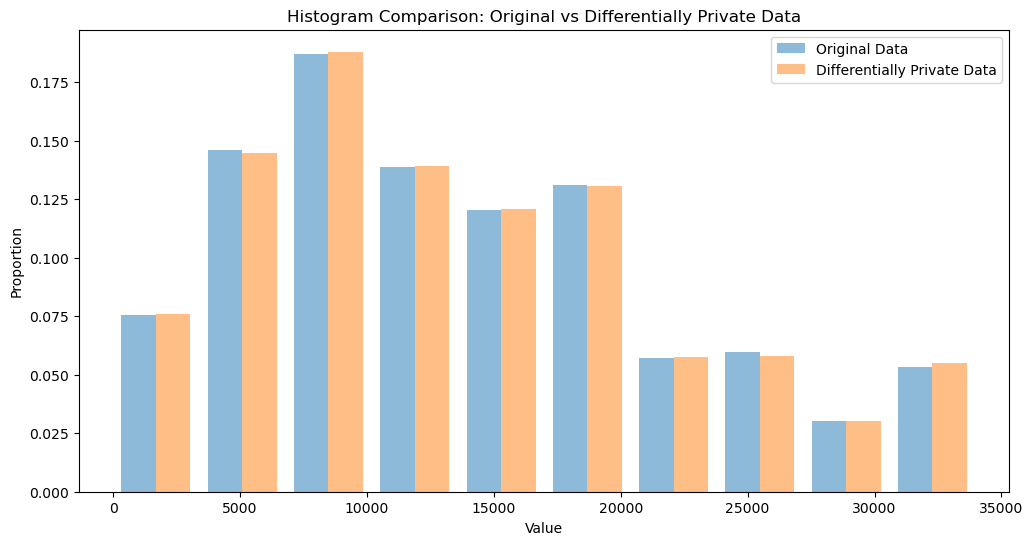

In [196]:
plt.figure(figsize=(12, 6))

plt.bar(bins_n[:-1], proportions_n, width=np.diff(bins_n) * 0.4, alpha=0.5, label='Original Data', align='center')
plt.bar(bins_a[:-1] + np.diff(bins_a) * 0.4, proportions_a, width=np.diff(bins_a) * 0.4, alpha=0.5, label='Differentially Private Data', align='center')

plt.xlabel('Value')
plt.ylabel('Proportion')
plt.title('Histogram Comparison: Original vs Differentially Private Data')
plt.legend()
plt.show()

### Budget for Privacy

In [201]:
accountant = BudgetAccountant(epsilon=1)

In [202]:
print(f"{column} Mean: {df[column].mean()}")
diff_avg = 0
iterations = 10
for i in range(iterations):
    avg = tools.mean(df[column],epsilon=epsilon,accountant=accountant)
    print(avg)
    diff_avg = diff_avg + avg

print(f"{column} Mean: {diff_avg/iterations}")


loan_amnt Mean: 14737.593152910853
14692.886606577844
14749.04825643691
14726.051567245908
14716.364802701213
14772.181864268385
14766.693941569085
14737.033105044376
14738.708447976105
14719.943851097643
14749.662653376918
loan_amnt Mean: 14736.85750962944


/Users/coding/anaconda3/envs/wrangling/lib/python3.9/site-packages/diffprivlib/tools/utils.py:276: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/Users/coding/anaconda3/envs/wrangling/lib/python3.9/site-packages/diffprivlib/tools/utils.py:276: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/Users/coding/anaconda3/envs/wrangling/lib/python3.9/site-packages/diffprivlib/tools/utils.py:276: Pri

In [207]:
for i in range(iterations):
    try:
        #Call till Budget is over
        diffprivlib.tools.mean(df[column],epsilon=epsilon,accountant=accountant)
    except diffprivlib.utils.BudgetError as e:
        print(f"BudgetError caught: {e}")


BudgetError caught: Privacy spend of (0.1,0) not permissible; will exceed remaining privacy budget. Use BudgetAccountant.remaining() to check remaining budget.
BudgetError caught: Privacy spend of (0.1,0) not permissible; will exceed remaining privacy budget. Use BudgetAccountant.remaining() to check remaining budget.
BudgetError caught: Privacy spend of (0.1,0) not permissible; will exceed remaining privacy budget. Use BudgetAccountant.remaining() to check remaining budget.
BudgetError caught: Privacy spend of (0.1,0) not permissible; will exceed remaining privacy budget. Use BudgetAccountant.remaining() to check remaining budget.
BudgetError caught: Privacy spend of (0.1,0) not permissible; will exceed remaining privacy budget. Use BudgetAccountant.remaining() to check remaining budget.
BudgetError caught: Privacy spend of (0.1,0) not permissible; will exceed remaining privacy budget. Use BudgetAccountant.remaining() to check remaining budget.
BudgetError caught: Privacy spend of (0.

/Users/coding/anaconda3/envs/wrangling/lib/python3.9/site-packages/diffprivlib/tools/utils.py:276: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/Users/coding/anaconda3/envs/wrangling/lib/python3.9/site-packages/diffprivlib/tools/utils.py:276: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/Users/coding/anaconda3/envs/wrangling/lib/python3.9/site-packages/diffprivlib/tools/utils.py:276: Pri

In [184]:
column

'loan_amnt'